**1. iniciando pyspark**

In [ ]:
#INSTALAR O SPARK NO COLAB
!pip install pyspark py4j

#IMPORTAR SPARK NO COLAB
from pyspark.sql import SparkSession

**2. preparação para extrair dados da tabela em html**

In [ ]:
#CRIAR SESSÃO SPARK
spark = SparkSession.builder.appName("HTML to DataFrame").getOrCreate()

In [ ]:
#IMPORTAÇÃO DE BIBLIOTECAS PARA SOLICITAÇÕES HTTP E ANÁLISE DE HTML
from bs4 import BeautifulSoup
import requests

In [ ]:
#LER O HTML ATRAVÉS DA URL
url = "https://fbref.com/pt/partidas/d3926429/Corinthians-Atletico-Mineiro-2024Abril14-Serie-A"
response = requests.get(url)
html_content = response.text

In [ ]:
#USAR BEAUTIFULSOUP PARA EXTRAIR INFORMAÇÕES
soup = BeautifulSoup(html_content, 'html.parser')

In [ ]:
#BUSCAR POR TABELA ESPECÍFICA ATRAVÉS DO ID
table = soup.find('table', {'id': 'stats_bf4acd28_possession'})

**3. definindo e trabalhando os dataframes**

In [ ]:
#IMPORTAÇÃO DE PANDAS
import pandas as pd

In [ ]:
#TRANSFORMAR A TABELA HTML EM UM DATAFRAME DO PANDAS
df_pandas = pd.read_html(str(table))[0]

In [ ]:
#CONVERTER O DATAFRAME DO PANDAS PARA UM DATAFRAME DO PYSPARK
df_spark = spark.createDataFrame(df_pandas)

In [ ]:
#VISUALIZAÇÃO DO DF EM PYSPARK
df_spark.show()

+---------------------------------+---------------------------+-------------------------------+------------------------------+-------------------------------+------------------------------+------------------------+-----------------------+-------------------------+-----------------------------+-------------------------------+-----------------------+-----------------------+-------------------+------------------+-------------------+-------------------+--------------------+--------------------------+------------------------+------------------------+---------------------+--------------------+--------------------+---------------------------------+--------------------+-------------------+--------------------+
|('Unnamed: 0_level_0', 'Jogador')|('Unnamed: 1_level_0', '#')|('Unnamed: 2_level_0', 'Nação')|('Unnamed: 3_level_0', 'Pos.')|('Unnamed: 4_level_0', 'Idade')|('Unnamed: 5_level_0', 'Min.')|('Contatos', 'Contatos')|('Contatos', 'Def Pen')|('Contatos', 'Terço Def')|('Contatos', 'Terço Cent

In [ ]:
#CRIANDO DATAFRAME DE INFORMAÇÕES DE POSICIONAMENTO EM PYSPARK
#DADOS:
posicionamento = [
    ('Goleiro', 2, 40),
    ('Ataque', 90, 40),
    ('Meio-atacante-esquerda', 85, 15),
    ('Meio-atacante-direita', 85, 65),
    ('Meio-atacante-meia', 70, 40),
    ('Meio-defensor-direita', 44, 60),
    ('Meio-defensor-centro', 44, 40),
    ('Meio-defensor-esquerda', 44, 20),
    ('Defesa-centro', 30, 40),
    ('Defesa-esquerda', 24, 30),
    ('Defesa-direita', 24, 50),
    ('Lateral-esquerdo', 55, 10),
    ('Lateral-direito', 55, 70)
]

df_posicionamento = spark.createDataFrame(posicionamento, ['posicao', 'y', 'x'])

In [ ]:
#CRIANDO DATAFRAME DE INFORMAÇÕES DOS JOGADORES EM PYSPARK
#DADOS:
jogadores = [
    ('Yuri Alberto', 'Ataque'),
    ('Wesley Ribeiro', 'Meio-atacante-esquerda'),
    ('Ángel Romero', 'Meio-atacante-direita'),
    ('Pedro Raul', 'Meio-atacante-direita'),
    ('Rodrigo Garro', 'Meio-atacante-meia'),
    ('Igor Coronado', 'Meio-atacante-meia'),
    ('Fausto Vera', 'Meio-defensor-direita'),
    ('Maycon', 'Meio-defensor-direita'),
    ('Raniele', 'Meio-defensor-esquerda'),
    ('Hugo', 'Defesa-direita'),
    ('Gustavo Henrique', 'Defesa-centro'),
    ('Paulinho', 'Meio-atacante-meia'),
    ('Félix Torres Caicedo', 'Defesa-esquerda'),
    ('Fagner', 'Lateral-esquerdo'),
    ('Matheuzinho', 'Lateral-direito'),
    ('Cássio', 'Goleiro')
]

df_jogadores = spark.createDataFrame(jogadores, ['nome', 'posicao'])

In [ ]:
#JUNTAR OS DATAFRAMES COM INFORMAÇÕES DE JOGADORES E POSICIONAMENTOS ATRAVES DA POSICAO
df_completo = df_jogadores.join(df_posicionamento, on='posicao', how='left')

In [ ]:
#VISUALIZAR MERGE TRUNCANDO AS COLUNAS
df_completo.show(truncate=False)

+----------------------+--------------------+---+---+
|posicao               |nome                |y  |x  |
+----------------------+--------------------+---+---+
|Meio-atacante-direita |Ángel Romero        |85 |65 |
|Meio-atacante-direita |Pedro Raul          |85 |65 |
|Ataque                |Yuri Alberto        |90 |40 |
|Meio-atacante-esquerda|Wesley Ribeiro      |85 |15 |
|Meio-atacante-meia    |Rodrigo Garro       |70 |40 |
|Meio-atacante-meia    |Igor Coronado       |70 |40 |
|Meio-defensor-direita |Fausto Vera         |44 |60 |
|Meio-defensor-direita |Maycon              |44 |60 |
|Goleiro               |Cássio              |2  |40 |
|Lateral-esquerdo      |Fagner              |55 |10 |
|Meio-defensor-esquerda|Raniele             |44 |20 |
|Defesa-centro         |Gustavo Henrique    |30 |40 |
|Meio-atacante-meia    |Paulinho            |70 |40 |
|Defesa-esquerda       |Félix Torres Caicedo|24 |30 |
|Defesa-direita        |Hugo                |24 |50 |
|Lateral-direito       |Math

**4. ajustando e complementando a análise através de funções do pyspark sql**

In [ ]:
#IMPORTAÇÃO DE FUNÇÕES
from pyspark.sql.functions import sum
from pyspark.sql.functions import round
from pyspark.sql.functions import col
from pyspark.sql.functions import lit

In [ ]:
#CRIAR UM DATAFRAME SEM A LINHA COM INFORMAÇÕES DO TOTAL DE JOGADORES
df_filtered = df_spark.filter(col("('Unnamed: 0_level_0', 'Jogador')") != '17 Jogadores')

In [ ]:
#CRIAR VARIÁVEIS NECESSÁRIAS PARA ANÁLISE

soma_total_cond = df_filtered.agg({"('Conduções', 'Conduções')": "sum"}).collect()[0][0]

df_filtered = df_filtered.withColumn(
    "%Conduções",
    round((col("('Conduções', 'Conduções')") / soma_total_cond * 100), 2)
)

soma_total_cdis = df_filtered.agg({"('Conduções', 'DistTot')": "sum"}).collect()[0][0]

df_filtered = df_filtered.withColumn(
    "%DistTotal",
    round((col("('Conduções', 'DistTot')") / soma_total_cdis * 100), 2)
)

soma_total_cdisat = df_filtered.agg({"('Conduções', 'DistPrg')": "sum"}).collect()[0][0]

df_filtered = df_filtered.withColumn(
    "%DistAtaque",
    round((col("('Conduções', 'DistPrg')") / soma_total_cdisat * 100), 2)
)

soma_total_cat9m = df_filtered.agg({"('Conduções', 'PrgC')": "sum"}).collect()[0][0]

df_filtered = df_filtered.withColumn(
    "%ProjAtaque9m",
    round((col("('Conduções', 'PrgC')") / soma_total_cat9m * 100), 2)
)

soma_total_perdadom = df_filtered.agg({"('Conduções', 'Perda de Domínio')": "sum"}).collect()[0][0]

df_filtered = df_filtered.withColumn(
    "%PerdaDomínio",
    round((col("('Conduções', 'Perda de Domínio')") / soma_total_perdadom * 100), 2)
)

soma_total_desarmes = df_filtered.agg({"('Conduções', 'Dis')": "sum"}).collect()[0][0]

df_filtered = df_filtered.withColumn(
    "%Desarmes",
    round((col("('Conduções', 'Dis')") / soma_total_desarmes * 100), 2)
)

In [ ]:
#JUNTAR OS DATAFRAMES JÁ CRIADOS
df_merged = df_filtered.join(
    df_completo,
    df_filtered["('Unnamed: 0_level_0', 'Jogador')"] == df_completo['nome'],
    how='inner'
)

In [ ]:
#CRIAR NOVAS COLUNAS NECESSÁRIAS PARA ANÁLISE NO DATAFRAME MAIS ATUALIZADO
df_merged = df_merged.withColumn(
    "inicio_ataque_x", col("x")
).withColumn(
    "inicio_ataque_y", col("y")
).withColumn(
    "fim_ataque_y", round(col("y") + ((col("%DistAtaque") * 120) / 100),2)
).withColumn(
    "fim_ataque_x", lit(40)
)

In [ ]:
#SELECIONAR VARIÁVEIS DE INTERESSE PARA VISUALIZAÇÃO ORGANIZADA
df_merged.select(
"('Unnamed: 0_level_0', 'Jogador')", "%Conduções", "%DistTotal", "%DistAtaque", "%ProjAtaque9m", "%PerdaDomínio", "%Desarmes",
  "x","y","inicio_ataque_x","inicio_ataque_y","fim_ataque_x","fim_ataque_y").show(truncate=False)

+---------------------------------+----------+----------+-----------+-------------+-------------+---------+---+---+---------------+---------------+------------+------------+
|('Unnamed: 0_level_0', 'Jogador')|%Conduções|%DistTotal|%DistAtaque|%ProjAtaque9m|%PerdaDomínio|%Desarmes|x  |y  |inicio_ataque_x|inicio_ataque_y|fim_ataque_x|fim_ataque_y|
+---------------------------------+----------+----------+-----------+-------------+-------------+---------+---+---+---------------+---------------+------------+------------+
|Wesley Ribeiro                   |12.95     |17.17     |19.79      |22.22        |27.27        |33.33    |15 |85 |15             |85             |40          |108.75      |
|Rodrigo Garro                    |10.88     |11.13     |5.76       |5.56         |9.09         |33.33    |40 |70 |40             |70             |40          |76.91       |
|Pedro Raul                       |0.0       |0.0       |0.0        |0.0          |0.0          |0.0      |65 |85 |65             

In [ ]:
#CRIAR LISTA COM JOGADORES TITULARES
jogadores_titulares = ['Cássio','Fagner','Félix Torres Caicedo','Hugo','Gustavo Henrique',
                       'Fausto Vera','Raniele','Rodrigo Garro','Ángel Romero','Yuri Alberto','Wesley Ribeiro']

In [ ]:
#FILTRAR LINHAS ONDE A COLUNA JOGADOR DO DATAFRAME CORRESPONDE COM A LISTA CRIADA
df_titulares = df_merged.filter(col("('Unnamed: 0_level_0', 'Jogador')").isin(jogadores_titulares))

**5. plotagem**

In [ ]:
#CONVERTER O DATAFRAME PARA PANDAS
df_titulares_pandas = df_titulares.toPandas()

In [ ]:
#INSTALAÇÕES E IMPORTAÇÕES NECESSÁRIAS
!pip install mplsoccer
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch

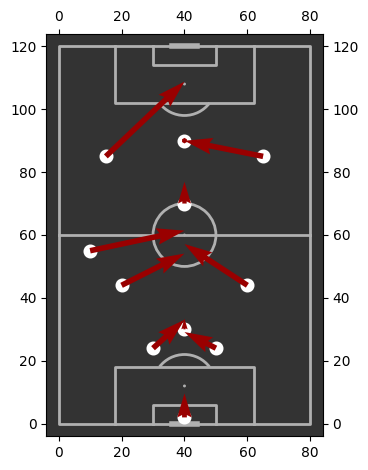

In [ ]:
#PLOTAGEM
#CRIAR O OBJETO DO PITCH
pitch = VerticalPitch(pitch_color='#333333', axis=True, label=True, tick=True)

#CRIAR A FIGURA E O EIXO
fig, ax = pitch.draw()

#PLOTAR OS PONTOS
ax.scatter(df_titulares_pandas['x'], df_titulares_pandas['y'], c='white', linewidth=3, s=50)

#ADICIONAR SETAS
pitch.arrows(df_titulares_pandas['y'], df_titulares_pandas['x'],
             df_titulares_pandas['fim_ataque_y'], df_titulares_pandas['fim_ataque_x'],
             ax=ax, zorder=1, color='#990000')

#EXIBIR O GRÁFICO
plt.show()